# Water mass transformation code
Adapted from Elizabeth Maroon

To calculate the WMT due to any other single process, read in any diag that contributes a freshwater flux, heat flux, or salt flux. It should be possible to fully decompose SHF and SFWF into different contributors. 

varsneeded for freshwater part => ['SFWF', 'EVAP_F', 'PREC_F', 'IOFF_F', 'SNOW_F', 'ROFF_F', 'SALT_F', 'MELT_F']   
varsneeded for heat part => ['SHF', 'QFLUX', 'LWDN_F', 'LWUP_F', 'SENH_F', 'SHF_QSW', 'MELTH_F'] 

Freshwater fluxes get treated the same as SFWF, while heat fluxes get treated the same as SHF. Salt fluxes (brine rejection and frazil) need to be scaled to a practical salinity and then get multiplied by beta to convert them to a surface density flux.  

NOTE: It would probably worthwhile checking with someone to ask about any other possible sources of transformation not included above. EBM? Robert filter? 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pop_tools
from datetime import timedelta
import glob

In [2]:
#choose cases and data paths
case1 = 'b.e21.B1850.f09_g17.CMIP6-piControl.001b'
case2 = 'b.e21.B1850.f09_g17.CMIP6-piControl.001_bl99b'
label1 = 'MUSHY'
label2 = 'BL99'

data_dir1 = '/glade/campaign/cgd/ppc/dbailey/'+case1+'/ocn/proc/tseries/month_1/'
data_dir2 = '/glade/campaign/cgd/ppc/dbailey/'+case2+'/ocn/proc/tseries/month_1/'

varsneeded = ['SALT', 'TEMP'] #to calculate surface density sigma_0
#vars needed for FW pieces
varsneeded = varsneeded + ['SFWF', 'EVAP_F', 'PREC_F', 'IOFF_F', 'SNOW_F', 'ROFF_F', 'SALT_F', 'MELT_F']   
#and vars needed for heat pieces
varsneeded = varsneeded + ['SHF', 'QFLUX', 'LWDN_F', 'LWUP_F', 'SENH_F', 'SHF_QSW', 'MELTH_F']  

In [3]:
%%time
#reading in files
ds1 = []
ds2 = []
for varname in varsneeded:
    print("loading "+varname)   
    # This loop takes a long time
    my_files=sorted(glob.glob(data_dir1+case1+'.pop.h.'+varname+'.*.nc'))[-2:]
    ds1.append(xr.open_mfdataset(my_files,combine='by_coords',chunks={}))
    my_files=sorted(glob.glob(data_dir2+case2+'.pop.h.'+varname+'.*.nc'))[-2:]
    ds2.append(xr.open_mfdataset(my_files,combine='by_coords',chunks={}))
    
    # TEST WITH SINGLE FILE OPENING
    #ds1.append(xr.open_dataset(data_dir1+case1+'.pop.h.'+varname+'.092101-097012.nc'))
    #ds2.append(xr.open_dataset(data_dir2+case2+'.pop.h.'+varname+'.092101-097012.nc'))

print("Merging files now")
ds1=xr.merge(ds1,compat='override')
ds2=xr.merge(ds2,compat='override')

loading SALT
loading TEMP
loading SFWF
loading EVAP_F
loading PREC_F
loading IOFF_F
loading SNOW_F
loading ROFF_F
loading SALT_F
loading MELT_F
loading SHF
loading QFLUX
loading LWDN_F
loading LWUP_F
loading SENH_F
loading SHF_QSW
loading MELTH_F
Merging files now
CPU times: user 5.86 s, sys: 469 ms, total: 6.33 s
Wall time: 13.1 s


## All S.Ocn south of 60S

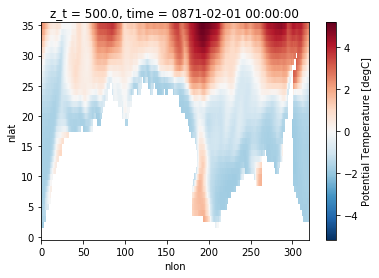

In [4]:
# Southern ocean: Everything 60S - 90S
box = {'nlat':slice(0,36), 'nlon':slice(0,320)}
#pulling only top layer and the region of interest
ds1=ds1.isel(z_t=0).sel(box)
ds2=ds2.isel(z_t=0).sel(box)

#test that masking worked properly
ds1["TEMP"].isel(time=0).plot()

In [5]:
%%time
# Takes ~8 min
ds1.load();
ds2.load();

CPU times: user 2min 54s, sys: 8.18 s, total: 3min 2s
Wall time: 3min 36s


<xarray.Dataset>
Dimensions:                 (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nlat: 36, nlon: 320, time: 1200, transport_comp: 5, transport_reg: 2, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
    z_t                     float32 500.0
  * z_t_150m                (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_w                     (z_w) float32 0.0 1000.0 ... 500004.7 525000.94
  * z_w_top                 (z_w_top) float32 0.0 1000.0 ... 500004.7 525000.94
  * z_w_bot                 (z_w_bot) float32 1000.0 2000.0 ... 549999.06
  * lat_aux_grid            (lat_aux_grid) float32 -79.48815 -78.952896 ... 90.0
  * moc_z                   (moc_z) float32 0.0 1000.0 ... 525000.94 549999.06
    ULONG                   (nlat, nlon) float64 321.1 322.3 ... 318.9 320.0
    ULAT                    (nlat, nlon) float64 -78.95 -78.95 ... -60.25 -60.25
    TLONG                   (nlat, nlon) float64 320.6 321.7 ... 318.3 319.4
    TLAT                    (nlat, nlon) float64 -79.22 -79.22 ... -60.52 -60.52
  * time                    (time) object 0871-02-01 00:00:00 ... 0971-01-01 ...
Dimensions without coordinates: d2, moc_comp, nlat, nlon, transport_comp, transport_reg
Data variables:
    moc_components          (time, moc_comp) |S384 b'Eulerian Mean' ... b'Sub...
    transport_components    (time, transport_comp) |S384 b'Total' ... b'Subme...
    transport_regions       (time, transport_reg) |S384 b'Global Ocean - Marg...
    dz                      (time) float32 1000.0 1000.0 ... 1000.0 1000.0
    dzw                     (time, z_w) float32 500.0 1000.0 ... 24997.176
    KMT                     (time, nlat, nlon) float64 0.0 0.0 0.0 ... 48.0 48.0
    KMU                     (time, nlat, nlon) float64 0.0 0.0 0.0 ... 47.0 46.0
    REGION_MASK             (time, nlat, nlon) float64 0.0 0.0 0.0 ... 1.0 1.0
    UAREA                   (time, nlat, nlon) float64 1.423e+13 ... 3.686e+13
    TAREA                   (time, nlat, nlon) float64 1.125e+13 ... 3.656e+13
    HU                      (time, nlat, nlon) float64 0.0 0.0 ... 2.075e+05
    HT                      (time, nlat, nlon) float64 0.0 0.0 ... 2.53e+05
    DXU                     (time, nlat, nlon) float64 2.397e+06 ... 6.206e+06
    DYU                     (time, nlat, nlon) float64 5.94e+06 ... 5.94e+06
    DXT                     (time, nlat, nlon) float64 1.894e+06 ... 6.155e+06
    DYT                     (time, nlat, nlon) float64 5.94e+06 ... 5.94e+06
    HTN                     (time, nlat, nlon) float64 2.397e+06 ... 6.206e+06
    HTE                     (time, nlat, nlon) float64 5.94e+06 ... 5.94e+06
    HUS                     (time, nlat, nlon) float64 2.397e+06 ... 6.155e+06
    HUW                     (time, nlat, nlon) float64 5.94e+06 ... 5.94e+06
    ANGLE                   (time, nlat, nlon) float64 0.0 0.0 0.0 ... 0.0 0.0
    ANGLET                  (time, nlat, nlon) float64 0.0 0.0 0.0 ... 0.0 0.0
    days_in_norm_year       (time) timedelta64[ns] 365 days ... 365 days
    grav                    (time) float64 980.6 980.6 980.6 ... 980.6 980.6
    omega                   (time) float64 7.292e-05 7.292e-05 ... 7.292e-05
    radius                  (time) float64 6.371e+08 6.371e+08 ... 6.371e+08
    cp_sw                   (time) float64 3.996e+07 3.996e+07 ... 3.996e+07
    sound                   (time) float64 1.5e+05 1.5e+05 ... 1.5e+05 1.5e+05
    vonkar                  (time) float64 0.4 0.4 0.4 0.4 ... 0.4 0.4 0.4 0.4
    cp_air                  (time) float64 1.005e+03 1.005e+03 ... 1.005e+03
    rho_air                 (time) float64 1.292 1.292 1.292 ... 1.292 1.292
    rho_sw                  (time) float64 1.026 1.026 1.026 ... 1.026 1.026
    rho_fw                  (time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    stefan_boltzmann        (time) float64 5.67e-08 5.67e-08 ... 5.67e-08
    latent_heat_vapor       (time) float64 2.501e+06 2.501e+06 ... 2.501e+06
    latent_heat_fusion      (tim

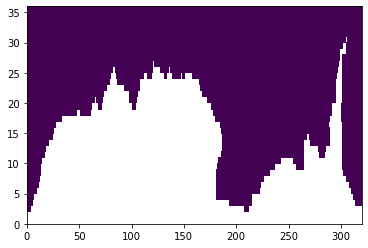

In [6]:
# set some values
s0=ds1['ocn_ref_salinity']
s0 = s0[0]
cp=ds1['cp_sw'].values/10000
cp = cp[0]
fusion=ds1['latent_heat_fusion'].values/100000
fusion = fusion[0]

# get grid information
tlat=ds1['TLAT']
tlon=ds1['TLONG']
tarea=ds1['TAREA']/(100*100)  # convert to m2
depth=ds1['z_t']
ht=ds1['HT']
depth_top=depth.where(depth<ht, np.nan)/100

# make a quick plot of the area the WMT is done over
plt.pcolormesh(depth_top.isel(time=0))

### Load Data from CASE1

In [7]:
## CASE1
salt1=ds1['SALT']
temp1=ds1['TEMP']

#get stuff from POP EOS
rho1,drhods1,drhodt1=pop_tools.eos(salt=salt1,temp=temp1,return_coefs=True,depth=depth_top)

#construct alpha and beta using POP methods
alpha1=-1*drhodt1/rho1
beta1=drhods1/rho1

In [8]:
#adjusting SHF to make for total heat part, adding QFLUX, then dividing by cp dw
shf_scaled1 = (ds1['SHF']+ds1['QFLUX'])/cp

#adjusting FW to remove the frazil part, then multiplying to turn salt flux into FW flux
fw_scaled1 = (ds1['SFWF'] - ds1['QFLUX']/fusion)*(salt1/1000)/(1-salt1/1000)

In [9]:
#multiply by alpha and beta to get density fluxes
heatpart1=-alpha1*shf_scaled1
fwpart1=-1*fw_scaled1*beta1

#combine to get total boundary forced density flux
densflux1=heatpart1+fwpart1

In [10]:
#Calculate components of the freshwater flux

#salt flux (brine rejection) part
#needs to be scaled from kg salt to a practical salinity
#then it can be multiplied by beta to convert to a surface density flux
salinity_factor1 = ds1['salinity_factor']
sflux_factor1 = ds1['sflux_factor']            
salt_f_fixed1 = ds1['SALT_F']*sflux_factor1/salinity_factor1  
saltpart1=-1*beta1*salt_f_fixed1

#freshwater flux from qflux (frazil) part
qflux_fw_fixed1 = -1*ds1['QFLUX']/fusion
frazilpart1=-1*beta1*qflux_fw_fixed1

#evaporation part
evappart1 = -1*beta1*(ds1['EVAP_F']*(salt1/1000)/(1-salt1/1000))

#ice melt part
meltpart1 = -1*beta1*(ds1['MELT_F']*(salt1/1000)/(1-salt1/1000))

#precip part
precippart1 = -1*beta1*(ds1['PREC_F']*(salt1/1000)/(1-salt1/1000))

#runoff part - sum of liquid and solid runoff
runoffpart1 = -1*beta1*((ds1['ROFF_F']+ds1['IOFF_F'])*(salt1/1000)/(1-salt1/1000))

#total salt reconstructed
fwpart_recons1 = saltpart1+frazilpart1+evappart1+meltpart1+precippart1+runoffpart1

In [11]:
# heat components - not going to get into these because heat flux is so much smaller than FW fluxes

##to get latent heat flux, need to convert EVAP_F from FW flux to heat flux via latent heat of vaporization
#vaporization = ds['latent_heat_vapor']

#latent_heat = ds['EVAP_F']*vaporization
##can now be multiplied by alpha to convert to a surf dens flux

##snow melt needs to be converted from a FW flux to a heat flux via latent heat of fusion
#snow_melt_heating = ds['SNOW_F']*fusion*-1
##Multiplied by negative one b/c melt (positive) leads to cooling (negative)
##can now be multiplied by alpha to convert to a surf dens flux

##same goes for ice melt runoff (solid)
#ioff_heating = ds['IOFF_F']*fusion*-1

### Load Data from CASE2

In [12]:
## CASE2
salt2=ds2['SALT']
temp2=ds2['TEMP']

#get stuff from POP EOS
rho2,drhods2,drhodt2=pop_tools.eos(salt=salt2,temp=temp2,return_coefs=True,depth=depth_top)

#construct alpha and beta using POP methods
alpha2=-1*drhodt2/rho2
beta2=drhods2/rho2

In [13]:
#adjusting SHF to make for total heat part, adding QFLUX, then dividing by cp dw
shf_scaled2 = (ds2['SHF']+ds2['QFLUX'])/cp

#adjusting FW to remove the frazil part, then multiplying to turn salt flux into FW flux
fw_scaled2 = (ds2['SFWF'] - ds2['QFLUX']/fusion)*(salt2/1000)/(1-salt2/1000)

In [14]:
#multiply by alpha and beta to get density fluxes
heatpart2=-alpha2*shf_scaled2
fwpart2=-1*fw_scaled2*beta2

#combine to get total boundary forced density flux
densflux2=heatpart2+fwpart2

In [15]:
#Calculate components of the freshwater flux

#salt flux (brine rejection) part
#needs to be scaled from kg salt to a practical salinity
#then it can be multiplied by beta to convert to a surface density flux
salinity_factor2 = ds2['salinity_factor']
sflux_factor2 = ds2['sflux_factor']            
salt_f_fixed2 = ds2['SALT_F']*sflux_factor2/salinity_factor2  
saltpart2=-1*beta2*salt_f_fixed2

#freshwater flux from qflux (frazil) part
qflux_fw_fixed2 = -1*ds2['QFLUX']/fusion
frazilpart2=-1*beta2*qflux_fw_fixed2

#evaporation part
evappart2 = -1*beta2*(ds2['EVAP_F']*(salt2/1000)/(1-salt2/1000))

#ice melt part
meltpart2 = -1*beta2*(ds2['MELT_F']*(salt2/1000)/(1-salt2/1000))

#precip part
precippart2 = -1*beta2*(ds2['PREC_F']*(salt2/1000)/(1-salt2/1000))

#runoff part - sum of liquid and solid runoff
runoffpart2 = -1*beta2*((ds2['ROFF_F']+ds2['IOFF_F'])*(salt2/1000)/(1-salt2/1000))

#total salt reconstructed
fwpart_recons2 = saltpart2+frazilpart2+evappart2+meltpart2+precippart2+runoffpart2

### Calculate WMT

In [16]:
#function for WMT 
def wmtrans(oneflux,dens_class,rho):
    binsize = dens_class[2]-dens_class[1]
    #assumes uniform density class spacing
    wmt=[]
    for ii in range(len(dens_class[0:-1])):
        densf_byclass = oneflux.where((rho>=dens_class[ii]) & (rho<dens_class[ii+1]),np.nan)
        wmt.append((densf_byclass*tarea).sum(['nlat','nlon'])/binsize)
    wmt = xr.concat(wmt, dim = sigma)
    return wmt
    
#set up density classes
binsize = 0.1 #typical value used
dens_class = np.arange(np.floor(rho1.min()),np.ceil(rho1.max()),binsize)
sigma = xr.DataArray(dens_class[0:-1]+binsize/2-1000, dims=['sigma'], coords={'sigma':dens_class[0:-1]+binsize/2-1000})


In [17]:
%%time
# Takes ~8.5 min
# CASE1
#calculate the WMT
wmt1 = wmtrans(densflux1, dens_class, rho1)
wmt1_heat = wmtrans(heatpart1, dens_class, rho1)
wmt1_fresh = wmtrans(fwpart1, dens_class, rho1)
#calculate WMF from WMT   
wmf1 = - wmt1.diff('sigma')/binsize
wmf1 = wmf1.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf1_fresh = - wmt1_fresh.diff('sigma')/binsize
wmf1_fresh = wmf1_fresh.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf1_heat = - wmt1_heat.diff('sigma')/binsize
wmf1_heat = wmf1_heat.assign_coords({'sigma':sigma[0:-1]+binsize/2})

CPU times: user 17.6 s, sys: 18.9 s, total: 36.5 s
Wall time: 37.2 s


In [18]:
%%time
# Takes ~8.5 min
# CASE2
#calculate the WMT
wmt2 = wmtrans(densflux2, dens_class, rho2)
wmt2_heat = wmtrans(heatpart2, dens_class, rho2)
wmt2_fresh = wmtrans(fwpart2, dens_class, rho2)
# calculate WMF from WMT  
wmf2 = - wmt2.diff('sigma')/binsize
wmf2 = wmf2.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf2_fresh = - wmt2_fresh.diff('sigma')/binsize
wmf2_fresh = wmf2_fresh.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf2_heat = - wmt2_heat.diff('sigma')/binsize
wmf2_heat = wmf2_heat.assign_coords({'sigma':sigma[0:-1]+binsize/2})

CPU times: user 17.7 s, sys: 18.3 s, total: 36 s
Wall time: 36.1 s


### Calculate WMT - individual FW terms

In [19]:
%%time
# ~20min
# CASE1 - FW terms
#calculate the WMT
wmt1_salt = wmtrans(saltpart1, dens_class, rho1)
wmt1_frazil = wmtrans(frazilpart1, dens_class, rho1)
wmt1_evap = wmtrans(evappart1, dens_class, rho1)
wmt1_melt = wmtrans(meltpart1, dens_class, rho1)
wmt1_precip = wmtrans(precippart1, dens_class, rho1)
wmt1_runoff = wmtrans(runoffpart1, dens_class, rho1)
wmt1_recons = wmtrans(fwpart_recons1, dens_class, rho1)

#calculate WMF from WMT   
wmf1_salt = - wmt1_salt.diff('sigma')/binsize
wmf1_salt = wmf1_salt.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf1_frazil = - wmt1_frazil.diff('sigma')/binsize
wmf1_frazil = wmf1_frazil.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf1_evap = - wmt1_evap.diff('sigma')/binsize
wmf1_evap = wmf1_evap.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf1_precip = - wmt1_precip.diff('sigma')/binsize
wmf1_precip = wmf1_precip.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf1_runoff = - wmt1_runoff.diff('sigma')/binsize
wmf1_runoff = wmf1_runoff.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf1_recons = - wmt1_recons.diff('sigma')/binsize
wmf1_recons = wmf1_recons.assign_coords({'sigma':sigma[0:-1]+binsize/2})

CPU times: user 41.1 s, sys: 42.9 s, total: 1min 23s
Wall time: 1min 24s


In [20]:
%%time
# ~20min
# CASE2 - FW terms
#calculate the WMT
wmt2_salt = wmtrans(saltpart2, dens_class, rho2)
wmt2_frazil = wmtrans(frazilpart2, dens_class, rho2)
wmt2_evap = wmtrans(evappart2, dens_class, rho2)
wmt2_melt = wmtrans(meltpart2, dens_class, rho2)
wmt2_precip = wmtrans(precippart2, dens_class, rho2)
wmt2_runoff = wmtrans(runoffpart2, dens_class, rho2)
wmt2_recons = wmtrans(fwpart_recons2, dens_class, rho2)

#calculate WMF from WMT   
wmf2_salt = - wmt2_salt.diff('sigma')/binsize
wmf2_salt = wmf2_salt.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf2_frazil = - wmt2_frazil.diff('sigma')/binsize
wmf2_frazil = wmf2_frazil.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf2_evap = - wmt2_evap.diff('sigma')/binsize
wmf2_evap = wmf2_evap.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf2_precip = - wmt2_precip.diff('sigma')/binsize
wmf2_precip = wmf2_precip.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf2_runoff = - wmt2_runoff.diff('sigma')/binsize
wmf2_runoff = wmf2_runoff.assign_coords({'sigma':sigma[0:-1]+binsize/2})
wmf2_recons = - wmt2_recons.diff('sigma')/binsize
wmf2_recons = wmf2_recons.assign_coords({'sigma':sigma[0:-1]+binsize/2})

CPU times: user 41.3 s, sys: 42.8 s, total: 1min 24s
Wall time: 1min 24s


### Calculate means and differences

In [21]:
# Get annual mean WMT values 
# CASE1
wmt1_ann = wmt1.mean(dim="time")
wmf1_ann = wmf1.mean(dim="time")
wmt1_fresh_ann = wmt1_fresh.mean(dim="time")
wmf1_fresh_ann = wmf1_fresh.mean(dim="time")
wmt1_heat_ann = wmt1_heat.mean(dim="time")
wmf1_heat_ann = wmf1_heat.mean(dim="time")
wmt1_salt_ann = wmt1_salt.mean(dim="time")
wmf1_salt_ann = wmf1_salt.mean(dim="time")
wmt1_frazil_ann = wmt1_frazil.mean(dim="time")
wmf1_frazil_ann = wmf1_frazil.mean(dim="time")
wmt1_evap_ann = wmt1_evap.mean(dim="time")
wmf1_evap_ann = wmf1_evap.mean(dim="time")
wmt1_precip_ann = wmt1_precip.mean(dim="time")
wmf1_precip_ann = wmf1_precip.mean(dim="time")
wmt1_runoff_ann = wmt1_runoff.mean(dim="time")
wmf1_runoff_ann = wmf1_runoff.mean(dim="time")
wmt1_recons_ann = wmt1_recons.mean(dim="time")
wmf1_recons_ann = wmf1_recons.mean(dim="time")

# CASE2
wmt2_ann = wmt2.mean(dim="time")
wmf2_ann = wmf2.mean(dim="time")
wmt2_fresh_ann = wmt2_fresh.mean(dim="time")
wmf2_fresh_ann = wmf2_fresh.mean(dim="time")
wmt2_heat_ann = wmt2_heat.mean(dim="time")
wmf2_heat_ann = wmf2_heat.mean(dim="time")
wmt2_salt_ann = wmt2_salt.mean(dim="time")
wmf2_salt_ann = wmf2_salt.mean(dim="time")
wmt2_frazil_ann = wmt2_frazil.mean(dim="time")
wmf2_frazil_ann = wmf2_frazil.mean(dim="time")
wmt2_evap_ann = wmt2_evap.mean(dim="time")
wmf2_evap_ann = wmf2_evap.mean(dim="time")
wmt2_precip_ann = wmt2_precip.mean(dim="time")
wmf2_precip_ann = wmf2_precip.mean(dim="time")
wmt2_runoff_ann = wmt2_runoff.mean(dim="time")
wmf2_runoff_ann = wmf2_runoff.mean(dim="time")
wmt2_recons_ann = wmt2_recons.mean(dim="time")
wmf2_recons_ann = wmf2_recons.mean(dim="time")

In [22]:
# calculate differences between two datasets
wmt_ann_diff = wmt1_ann - wmt2_ann
wmf_ann_diff = wmf1_ann - wmf2_ann

wmt_fresh_ann_diff = wmt1_fresh_ann - wmt2_fresh_ann
wmf_fresh_ann_diff = wmf1_fresh_ann - wmf2_fresh_ann

wmt_heat_ann_diff = wmt1_heat_ann - wmt2_heat_ann
wmf_heat_ann_diff = wmf1_heat_ann - wmf2_heat_ann

### Plot the results

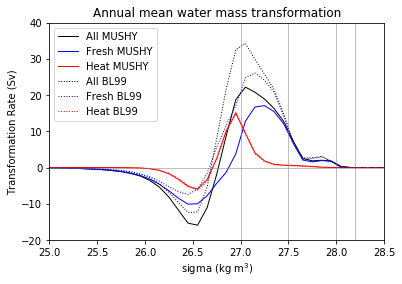

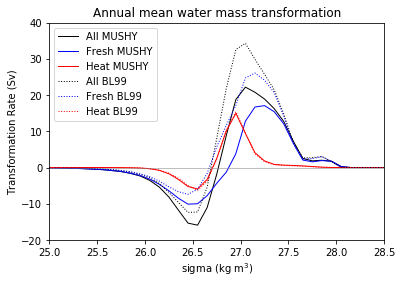

In [29]:
#Plot transformations averaged over all time
f=plt.figure()
plt.plot(wmt1_ann.sigma,wmt1_ann/1e6,label="All "+label1,color='black',linestyle='-', linewidth=1)
plt.plot(wmt1_fresh_ann.sigma,wmt1_fresh_ann/1e6,label="Fresh "+label1,color='blue',linestyle='-', linewidth=1)
plt.plot(wmt1_heat_ann.sigma,wmt1_heat_ann/1e6,label="Heat "+label1,color='red',linestyle='-', linewidth=1)
plt.plot(wmt2_ann.sigma,wmt2_ann/1e6,label="All "+label2,color='black',linestyle=':', linewidth=1)
plt.plot(wmt2_fresh_ann.sigma,wmt2_fresh_ann/1e6,label="Fresh "+label2,color='blue',linestyle=':', linewidth=1)
plt.plot(wmt2_heat_ann.sigma,wmt2_heat_ann/1e6,label="Heat "+label2,color='red',linestyle=':', linewidth=1)
plt.title('Annual mean water mass transformation')
plt.xlabel('sigma (kg m$^3$)')
plt.xlim([25,28.5])
plt.ylabel('Transformation Rate (Sv)')
plt.ylim([-20,40])
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.axvline(x=27.0, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=27.5, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=28.0, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=28.2, color='grey', linestyle='-',linewidth=0.5)
plt.legend()
plt.savefig('socn_WMT_'+label1+'_and_'+label2+'.png', bbox_inches='tight', dpi=200)

#Plot transformations averaged over all time
f=plt.figure()
plt.plot(wmt1_ann.sigma,wmt1_ann/1e6,label="All "+label1,color='black',linestyle='-', linewidth=1)
plt.plot(wmt1_fresh_ann.sigma,wmt1_fresh_ann/1e6,label="Fresh "+label1,color='blue',linestyle='-', linewidth=1)
plt.plot(wmt1_heat_ann.sigma,wmt1_heat_ann/1e6,label="Heat "+label1,color='red',linestyle='-', linewidth=1)
plt.plot(wmt2_ann.sigma,wmt2_ann/1e6,label="All "+label2,color='black',linestyle=':', linewidth=1)
plt.plot(wmt2_fresh_ann.sigma,wmt2_fresh_ann/1e6,label="Fresh "+label2,color='blue',linestyle=':', linewidth=1)
plt.plot(wmt2_heat_ann.sigma,wmt2_heat_ann/1e6,label="Heat "+label2,color='red',linestyle=':', linewidth=1)
plt.title('Annual mean water mass transformation')
plt.xlabel('sigma (kg m$^3$)')
plt.xlim([25,28.5])
plt.ylabel('Transformation Rate (Sv)')
plt.ylim([-20,40])
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.legend()
plt.savefig('socn_WMT_'+label1+'_and_'+label2+'_nolines.png', bbox_inches='tight', dpi=200)

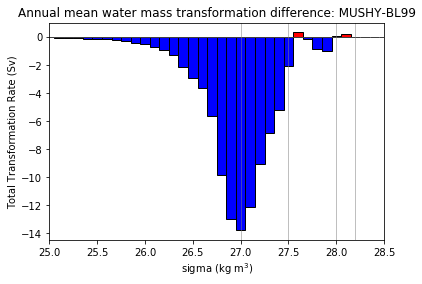

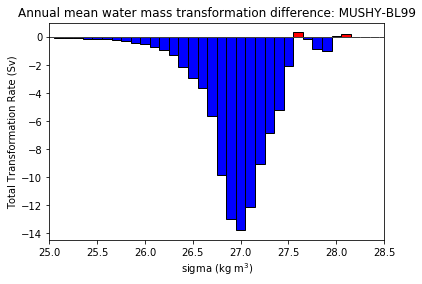

In [24]:
colors = ['red' if (value > 0) else 'blue' for value in wmt_ann_diff]

f=plt.figure()
plt.bar(wmt_ann_diff.sigma,wmt_ann_diff/1e6,align='edge',edgecolor='black',color=colors,width=0.1)
plt.title('Annual mean water mass transformation difference: '+label1+'-'+label2)
plt.xlabel('sigma (kg m$^3$)')
plt.xlim([25,28.5])
plt.ylabel('Total Transformation Rate (Sv)')
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.axvline(x=27.0, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=27.5, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=28.0, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=28.2, color='grey', linestyle='-',linewidth=0.5)
plt.savefig('socn_WMT_diff_'+label1+'_minus_'+label2+'.png', bbox_inches='tight', dpi=200)

f=plt.figure()
plt.bar(wmt_ann_diff.sigma,wmt_ann_diff/1e6,align='edge',edgecolor='black',color=colors,width=0.1)
plt.title('Annual mean water mass transformation difference: '+label1+'-'+label2)
plt.xlabel('sigma (kg m$^3$)')
plt.xlim([25,28.5])
plt.ylabel('Total Transformation Rate (Sv)')
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.savefig('socn_WMT_diff_'+label1+'_minus_'+label2+'_nolines.png', bbox_inches='tight', dpi=200)


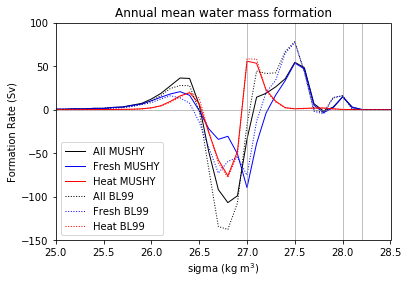

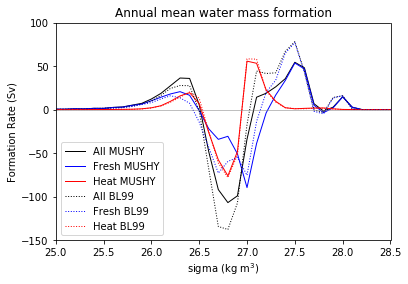

In [32]:
#Plot formation averaged over all time
f=plt.figure()
plt.plot(wmf1_ann.sigma,wmf1_ann/1e6,label="All "+label1,color='black',linestyle='-', linewidth=1)
plt.plot(wmf1_fresh_ann.sigma,wmf1_fresh_ann/1e6,label="Fresh "+label1,color='blue',linestyle='-', linewidth=1)
plt.plot(wmf1_heat_ann.sigma,wmf1_heat_ann/1e6,label="Heat "+label1,color='red',linestyle='-', linewidth=1)
plt.plot(wmf2_ann.sigma,wmf2_ann/1e6,label="All "+label2,color='black',linestyle=':', linewidth=1)
plt.plot(wmf2_fresh_ann.sigma,wmf2_fresh_ann/1e6,label="Fresh "+label2,color='blue',linestyle=':', linewidth=1)
plt.plot(wmf2_heat_ann.sigma,wmf2_heat_ann/1e6,label="Heat "+label2,color='red',linestyle=':', linewidth=1)
plt.title('Annual mean water mass formation')
plt.xlabel('sigma (kg m$^3$)')
plt.xlim([25,28.5])
plt.ylabel('Formation Rate (Sv)')
plt.ylim([-150,100])
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.axvline(x=27.0, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=27.5, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=28.0, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=28.2, color='grey', linestyle='-',linewidth=0.5)
plt.legend()
plt.savefig('socn_WMF_'+label1+'_and_'+label2+'.png', bbox_inches='tight', dpi=200)

#Plot transformations averaged over all time
f=plt.figure()
plt.plot(wmf1_ann.sigma,wmf1_ann/1e6,label="All "+label1,color='black',linestyle='-', linewidth=1)
plt.plot(wmf1_fresh_ann.sigma,wmf1_fresh_ann/1e6,label="Fresh "+label1,color='blue',linestyle='-', linewidth=1)
plt.plot(wmf1_heat_ann.sigma,wmf1_heat_ann/1e6,label="Heat "+label1,color='red',linestyle='-', linewidth=1)
plt.plot(wmf2_ann.sigma,wmf2_ann/1e6,label="All "+label2,color='black',linestyle=':', linewidth=1)
plt.plot(wmf2_fresh_ann.sigma,wmf2_fresh_ann/1e6,label="Fresh "+label2,color='blue',linestyle=':', linewidth=1)
plt.plot(wmf2_heat_ann.sigma,wmf2_heat_ann/1e6,label="Heat "+label2,color='red',linestyle=':', linewidth=1)
plt.title('Annual mean water mass formation')
plt.xlabel('sigma (kg m$^3$)')
plt.xlim([25,28.5])
plt.ylabel('Formation Rate (Sv)')
plt.ylim([-150,100])
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.legend()
plt.savefig('socn_WMF_'+label1+'_and_'+label2+'_nolines.png', bbox_inches='tight', dpi=200)

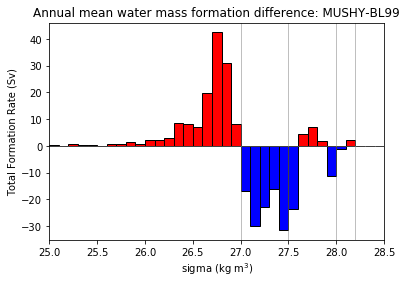

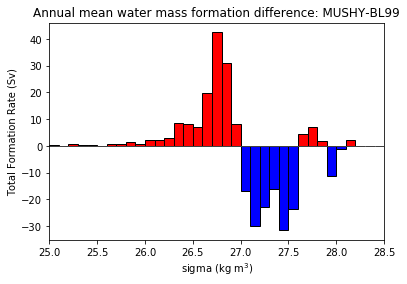

In [33]:
colors = ['red' if (value > 0) else 'blue' for value in wmf_ann_diff]

f=plt.figure()
plt.bar(wmf_ann_diff.sigma,wmf_ann_diff/1e6,align='edge',edgecolor='black',color=colors,width=0.1)
plt.title('Annual mean water mass formation difference: '+label1+'-'+label2)
plt.xlabel('sigma (kg m$^3$)')
plt.xlim([25,28.5])
plt.ylabel('Total Formation Rate (Sv)')
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.axvline(x=27.0, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=27.5, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=28.0, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=28.2, color='grey', linestyle='-',linewidth=0.5)
plt.savefig('socn_WMF_diff_'+label1+'_minus_'+label2+'.png', bbox_inches='tight', dpi=200)

f=plt.figure()
plt.bar(wmf_ann_diff.sigma,wmf_ann_diff/1e6,align='edge',edgecolor='black',color=colors,width=0.1)
plt.title('Annual mean water mass formation difference: '+label1+'-'+label2)
plt.xlabel('sigma (kg m$^3$)')
plt.xlim([25,28.5])
plt.ylabel('Total Formation Rate (Sv)')
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.savefig('socn_WMF_diff_'+label1+'_minus_'+label2+'_nolines.png', bbox_inches='tight', dpi=200)

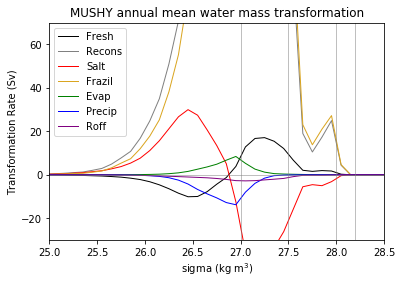

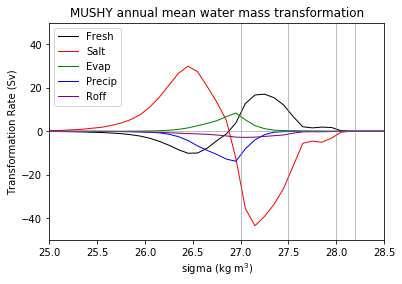

In [34]:
#Plot transformation components averaged over all time
f=plt.figure()
plt.plot(wmt1_fresh_ann.sigma,wmt1_fresh_ann/1e6,label="Fresh",color='black',linestyle='-', linewidth=1)
plt.plot(wmt1_recons_ann.sigma,wmt1_recons_ann/1e6,label="Recons",color='grey',linestyle='-', linewidth=1)
plt.plot(wmt1_salt_ann.sigma,wmt1_salt_ann/1e6,label="Salt",color='red',linestyle='-', linewidth=1)
plt.plot(wmt1_frazil_ann.sigma,wmt1_frazil_ann/1e6,label="Frazil",color='goldenrod',linestyle='-', linewidth=1)
plt.plot(wmt1_evap_ann.sigma,wmt1_evap_ann/1e6,label="Evap",color='green',linestyle='-', linewidth=1)
plt.plot(wmt1_precip_ann.sigma,wmt1_precip_ann/1e6,label="Precip",color='blue',linestyle='-', linewidth=1)
plt.plot(wmt1_runoff_ann.sigma,wmt1_runoff_ann/1e6,label="Roff",color='purple',linestyle='-', linewidth=1)
plt.title(label1+' annual mean water mass transformation')
plt.xlabel('sigma (kg m$^3$)')
plt.xlim([25,28.5])
plt.ylabel('Transformation Rate (Sv)')
plt.ylim([-30,70])
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.axvline(x=27.0, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=27.5, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=28.0, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=28.2, color='grey', linestyle='-',linewidth=0.5)
plt.legend()
#plt.savefig('socn_WMT_components_'+label1+'.png', bbox_inches='tight', dpi=200)

#Plot transformation components averaged over all time
f=plt.figure()
plt.plot(wmt1_fresh_ann.sigma,wmt1_fresh_ann/1e6,label="Fresh",color='black',linestyle='-', linewidth=1)
plt.plot(wmt1_salt_ann.sigma,wmt1_salt_ann/1e6,label="Salt",color='red',linestyle='-', linewidth=1)
plt.plot(wmt1_evap_ann.sigma,wmt1_evap_ann/1e6,label="Evap",color='green',linestyle='-', linewidth=1)
plt.plot(wmt1_precip_ann.sigma,wmt1_precip_ann/1e6,label="Precip",color='blue',linestyle='-', linewidth=1)
plt.plot(wmt1_runoff_ann.sigma,wmt1_runoff_ann/1e6,label="Roff",color='purple',linestyle='-', linewidth=1)
plt.title(label1+' annual mean water mass transformation')
plt.xlabel('sigma (kg m$^3$)')
plt.xlim([25,28.5])
plt.ylabel('Transformation Rate (Sv)')
plt.ylim([-50,50])
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.axvline(x=27.0, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=27.5, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=28.0, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=28.2, color='grey', linestyle='-',linewidth=0.5)
plt.legend()
plt.savefig('socn_WMT_components_'+label1+'.png', bbox_inches='tight', dpi=200)


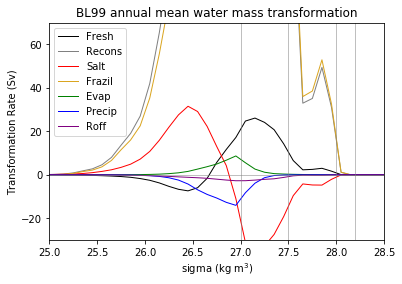

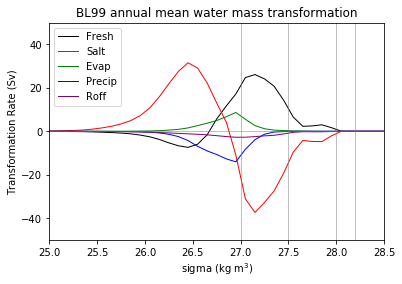

In [35]:
#Plot transformation components averaged over all time
f=plt.figure()
plt.plot(wmt2_fresh_ann.sigma,wmt2_fresh_ann/1e6,label="Fresh",color='black',linestyle='-', linewidth=1)
plt.plot(wmt2_recons_ann.sigma,wmt2_recons_ann/1e6,label="Recons",color='grey',linestyle='-', linewidth=1)
plt.plot(wmt2_salt_ann.sigma,wmt2_salt_ann/1e6,label="Salt",color='red',linestyle='-', linewidth=1)
plt.plot(wmt2_frazil_ann.sigma,wmt2_frazil_ann/1e6,label="Frazil",color='goldenrod',linestyle='-', linewidth=1)
plt.plot(wmt2_evap_ann.sigma,wmt2_evap_ann/1e6,label="Evap",color='green',linestyle='-', linewidth=1)
plt.plot(wmt2_precip_ann.sigma,wmt2_precip_ann/1e6,label="Precip",color='blue',linestyle='-', linewidth=1)
plt.plot(wmt2_runoff_ann.sigma,wmt2_runoff_ann/1e6,label="Roff",color='purple',linestyle='-', linewidth=1)
plt.title(label2+' annual mean water mass transformation')
plt.xlabel('sigma (kg m$^3$)')
plt.xlim([25,28.5])
plt.ylabel('Transformation Rate (Sv)')
plt.ylim([-30,70])
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.axvline(x=27.0, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=27.5, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=28.0, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=28.2, color='grey', linestyle='-',linewidth=0.5)
plt.legend()
#plt.savefig('socn_WMT_components_'+label2+'.png', bbox_inches='tight', dpi=200)

#Plot transformation components averaged over all time
f=plt.figure()
plt.plot(wmt2_fresh_ann.sigma,wmt2_fresh_ann/1e6,label="Fresh",color='black',linestyle='-', linewidth=1)
plt.plot(wmt2_salt_ann.sigma,wmt2_salt_ann/1e6,label="Salt",color='red',linestyle='-', linewidth=1)
plt.plot(wmt2_evap_ann.sigma,wmt2_evap_ann/1e6,label="Evap",color='green',linestyle='-', linewidth=1)
plt.plot(wmt2_precip_ann.sigma,wmt2_precip_ann/1e6,label="Precip",color='blue',linestyle='-', linewidth=1)
plt.plot(wmt2_runoff_ann.sigma,wmt2_runoff_ann/1e6,label="Roff",color='purple',linestyle='-', linewidth=1)
plt.title(label2+' annual mean water mass transformation')
plt.xlabel('sigma (kg m$^3$)')
plt.xlim([25,28.5])
plt.ylabel('Transformation Rate (Sv)')
plt.ylim([-50,50])
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.axvline(x=27.0, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=27.5, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=28.0, color='grey', linestyle='-',linewidth=0.5)
plt.axvline(x=28.2, color='grey', linestyle='-',linewidth=0.5)
plt.legend()
plt.savefig('socn_WMT_components_'+label2+'.png', bbox_inches='tight', dpi=200)


## Outdated plotting below this line

In [ ]:
#Plot total transformation - just first timestep to check
f=plt.figure()
plt.plot(wmt1.sigma,wmt1.isel(time=0)/1e6,label=label1)
plt.plot(wmt2.sigma,wmt2.isel(time=0)/1e6,label=label2)
plt.xlabel('sigma')
plt.ylabel('WMT (Sv)')

#formation
f=plt.figure()
plt.plot(wmf1.sigma,wmf1.isel(time=0)/1e6,label=label1)
plt.plot(wmf2.sigma,wmf2.isel(time=0)/1e6,label=label2)
plt.xlabel('sigma')
plt.ylabel('WMF (Sv)')

In [ ]:
#Plot transformations averaged over all time
f=plt.figure()
plt.plot(wmt1_ann.sigma,wmt1_ann/1e6,label="All",color='black')
plt.plot(wmt1_fresh_ann.sigma,wmt1_fresh_ann/1e6,label="Fresh",color='blue',linestyle='--')
plt.plot(wmt1_heat_ann.sigma,wmt1_heat_ann/1e6,label="Heat",color='goldenrod',linestyle='--')
plt.title('Annual mean: '+label1)
plt.xlabel('sigma')
plt.xlim([25,28.5])
plt.ylabel('Transformation Rate (Sv)')
plt.ylim([-5,25])
#plt.ylim([-20,5])
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.legend()
plt.savefig(label1+'_socn_WMT.png', bbox_inches='tight', dpi=200)

f=plt.figure()
plt.plot(wmt2_ann.sigma,wmt2_ann/1e6,label="All",color='black')
plt.plot(wmt2_fresh_ann.sigma,wmt2_fresh_ann/1e6,label="Fresh",color='blue',linestyle='--')
plt.plot(wmt2_heat_ann.sigma,wmt2_heat_ann/1e6,label="Heat",color='goldenrod',linestyle='--')
plt.title('Annual mean: '+label2)
plt.xlabel('sigma')
plt.xlim([25,28.5])
plt.ylabel('Transformation Rate (Sv)')
plt.ylim([-5,25])
#plt.ylim([-20,5])
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.legend()
plt.savefig(label2+'_socn_WMT.png', bbox_inches='tight', dpi=200)

#Plot difference in transformation averaged over all time
f=plt.figure()
plt.plot(wmt_ann_diff.sigma,wmt_ann_diff/1e6,label="All",color='black')
plt.plot(wmt_fresh_ann_diff.sigma,wmt_fresh_ann_diff/1e6,label="Fresh",color='blue',linestyle='--')
plt.plot(wmt_heat_ann_diff.sigma,wmt_heat_ann_diff/1e6,label="Heat",color='goldenrod',linestyle='--')
plt.title('Annual mean diff: '+label1+'-'+label2)
plt.xlabel('sigma')
plt.xlim([25,28.5])
plt.ylabel('Transformation Rate (Sv)')
plt.ylim([-10,1])
#plt.ylim([-1,3])
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.legend()
plt.savefig(label1+'_minus_'+label2+'_socn_WMT.png', bbox_inches='tight', dpi=200)

In [ ]:
#Plot formations averaged over all time
f=plt.figure()
plt.plot(wmf1_ann.sigma,wmf1_ann/1e6,label="All",color='black')
plt.plot(wmf1_fresh_ann.sigma,wmf1_fresh_ann/1e6,label="Fresh",color='blue',linestyle='--')
plt.plot(wmf1_heat_ann.sigma,wmf1_heat_ann/1e6,label="Heat",color='goldenrod',linestyle='--')
plt.title('Annual mean: '+label1)
plt.xlabel('sigma')
plt.xlim([25,28.5])
plt.ylabel('Formation Rate (Sv)')
plt.ylim([-60,70])
plt.axhline(y=0.0, color='grey', linestyle='-', linewidth=0.5)
plt.legend()
plt.savefig(label1+'_socn_WMF.png', bbox_inches='tight', dpi=200)

f=plt.figure()
plt.plot(wmf2_ann.sigma,wmf2_ann/1e6,label="All",color='black')
plt.plot(wmf2_fresh_ann.sigma,wmf2_fresh_ann/1e6,label="Fresh",color='blue',linestyle='--')
plt.plot(wmf2_heat_ann.sigma,wmf2_heat_ann/1e6,label="Heat",color='goldenrod',linestyle='--')
plt.title('Annual mean: '+label2)
plt.xlabel('sigma')
plt.xlim([25,28.5])
plt.ylabel('Formation Rate (Sv)')
plt.ylim([-60,70])
plt.axhline(y=0.0, color='grey', linestyle='-')
plt.legend()
plt.savefig(label2+'_socn_WMF.png', bbox_inches='tight', dpi=200)

#Plot difference in transformation averaged over all time
f=plt.figure()
plt.plot(wmf_ann_diff.sigma,wmf_ann_diff/1e6,label="All",color='black')
plt.plot(wmf_fresh_ann_diff.sigma,wmf_fresh_ann_diff/1e6,label="Fresh",color='blue',linestyle='--')
plt.plot(wmf_heat_ann_diff.sigma,wmf_heat_ann_diff/1e6,label="Heat",color='goldenrod',linestyle='--')
plt.title('Annual mean diff: '+label1+'-'+label2)
plt.xlabel('sigma')
plt.xlim([25,28.5])
plt.ylabel('Formation Rate (Sv)')
plt.ylim([-30,30])
plt.axhline(y=0.0, color='grey', linestyle='-')
plt.legend()
plt.savefig(label1+'_minus_'+label2+'_socn_WMF.png', bbox_inches='tight', dpi=200)

#### old WMT calculation (pre function)

In [ ]:
# OLD WAY
#calculate the WMT (total)
#wmt1=[]
#for ii in range(len(dens_class[0:-1])):
#    # CASE 1
#    densf_byclass = densflux1.where((rho1>=dens_class[ii]) & (rho1<dens_class[ii+1]),np.nan)
#    wmt1.append((densf_byclass*tarea).sum(['nlat','nlon'])/binsize)

# Set sigma as a coordinate in the arrays
#wmt1 = xr.concat(wmt1, dim = sigma)   
#wmf1 = - wmt1.diff('sigma')/binsize
#wmf1 = wmf1.assign_coords({'sigma':sigma[0:-1]+binsize/2})